In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from transformers import BertModel, BertConfig, AutoTokenizer
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap

# For better plots
plt.style.use('seaborn-v0_8')
sns.set_context("notebook")


In [2]:
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

def global_ap(x):
    return torch.mean(x.view(x.size(0), x.size(1), -1), dim=1)

class SimSonEncoder(nn.Module):
    def __init__(self, config: BertConfig, max_len: int, dropout: float = 0.1):
        super(SimSonEncoder, self).__init__()
        self.config = config
        self.max_len = max_len
        
        self.bert = BertModel(config, add_pooling_layer=False)
        
        self.linear = nn.Linear(config.hidden_size, max_len)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input_ids, attention_mask=None):
        if attention_mask is None:
            attention_mask = input_ids.ne(0)
            
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        
        hidden_states = outputs.last_hidden_state
        
        hidden_states = self.dropout(hidden_states)
        
        pooled = global_ap(hidden_states)
        
        out = self.linear(pooled)
        
        return out

class SimSonClassifier(nn.Module):
    def __init__(self, encoder: SimSonEncoder, num_labels: int, dropout=0.1):
        super(SimSonClassifier, self).__init__()
        self.encoder = encoder
        self.clf = nn.Linear(encoder.max_len, num_labels)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, input_ids, attention_mask=None, labels=None):
        x = self.encoder(input_ids, attention_mask)
        x = self.relu(self.dropout(x))
        x = self.clf(x)
        return x

In [3]:
# Load test data
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler

df = pd.read_csv('/home/jovyan/simson_training_bolgov/regression/PI_Tg_P308K_synth_db_chem.csv')

In [4]:
from sklearn.metrics import pairwise_distances
from sklearn.model_selection import train_test_split


def create_stratified_splits_regression(
    df,
    label_cols,
    n_bins=10,
    val_frac=0.05,
    seed=42
):
 
    values = df[label_cols].values
    # Each label gets its own bins, based on the overall distribution
    bins = [np.unique(np.quantile(values[:,i], np.linspace(0, 1, n_bins+1))) for i in range(len(label_cols))]
    # Assign each row to a bin for each label
    inds = [
        np.digitize(values[:,i], bins[i][1:-1], right=False)  # exclude leftmost/rightmost for in-bin, avoids all bin edges as bins
        for i in range(len(label_cols))
    ]
    # Combine into a single integer stratification variable (tuple or max or sum...)
    strat_col = np.maximum.reduce(inds)  # This ensures high bin in one = high bin overall
    # Use sklearn's train_test_split with stratify
    train_idx, val_idx = train_test_split(
        df.index.values,
        test_size=val_frac,
        random_state=seed,
        shuffle=True,
        stratify=strat_col
    )
    train = df.loc[train_idx].reset_index(drop=True)
    val = df.loc[val_idx].reset_index(drop=True)
    return train, val


# For your use case:
train, test = create_stratified_splits_regression(
    df,
    label_cols=['CO2', 'CH4'],  # or actual column names
    n_bins=10,
    val_frac=0.05,
    seed=42
)


# --- 2. columns that hold permeability values --------------------------------
features = ['CO2', 'CH4']   # adjust if names differ

# --- 3. Max–Min selection ----------------------------------------------------
def select_diverse_maxmin(data, cols, k=1_000):
    X = data[cols].to_numpy()
    
    # scale to [0,1] so CO₂ and CH₄ get equal weight
    X = MinMaxScaler().fit_transform(X)
    
    n = len(X)
    if k >= n:                       # nothing to do
        return data
    
    # start with a random seed point
    selected = [np.random.randint(0, n)]
    
    # pre-allocate distance cache
    min_dist = pairwise_distances(
        X, X[selected], metric='euclidean'
    ).ravel()          # distance to first point
    
    for _ in tqdm(range(1, k)):
        # pick the point with the largest distance to the current set
        idx = np.argmax(min_dist)
        selected.append(idx)
        
        # update distance cache (keep the shortest distance to any selected pt)
        dist_to_new = pairwise_distances(X, X[[idx]], metric='euclidean').ravel()
        min_dist = np.minimum(min_dist, dist_to_new)
    
    return data.iloc[selected].reset_index(drop=True)

diverse_test = select_diverse_maxmin(test, features, k=1_000)
print(diverse_test.shape)   # (1000, …)


100%|█████████████████████████████████████████████████████████████████████████████████| 999/999 [00:29<00:00, 33.87it/s]


(1000, 9)


In [12]:
tokenizer_path = 'DeepChem/ChemBERTa-77M-MTR'
tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)

# Load scalers (list of 6), only last 2 needed for CO2 and CH4 permeability
scalers = joblib.load('/home/jovyan/simson_training_bolgov/regression/scalers')
scaler_co2 = scalers[-1]
scaler_ch4 = scalers[-2]

# Torch model definitions (SimSonEncoder and SimSonClassifier as in your code)
# --paste classes global_ap, SimSonEncoder, SimSonClassifier here--

config = BertConfig(
    vocab_size=tokenizer.vocab_size,
    hidden_size=768,
    num_hidden_layers=4,
    num_attention_heads=12,
    intermediate_size=2048,
    max_position_embeddings=512
)

simson_params_clf = torch.load('/home/jovyan/simson_training_bolgov/regression/better_regression_states/best_state.bin')

backbone = SimSonEncoder(config=config, max_len=512)
backbone = torch.compile(backbone)
model = SimSonClassifier(encoder=backbone, num_labels=6)  # 6 outputs as per full regression
model = torch.compile(model, fullgraph=True)
model.load_state_dict(simson_params_clf)
model.eval()

/tmp/ipykernel_240462/477882228.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  simson_params_clf = torch.load('/home/jovyan/simson_training_bolgov/regression/regressio

OptimizedModule(
  (_orig_mod): SimSonClassifier(
    (encoder): OptimizedModule(
      (_orig_mod): SimSonEncoder(
        (bert): BertModel(
          (embeddings): BertEmbeddings(
            (word_embeddings): Embedding(591, 768, padding_idx=0)
            (position_embeddings): Embedding(512, 768)
            (token_type_embeddings): Embedding(2, 768)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (encoder): BertEncoder(
            (layer): ModuleList(
              (0-3): 4 x BertLayer(
                (attention): BertAttention(
                  (self): BertSdpaSelfAttention(
                    (query): Linear(in_features=768, out_features=768, bias=True)
                    (key): Linear(in_features=768, out_features=768, bias=True)
                    (value): Linear(in_features=768, out_features=768, bias=True)
                    (dropout): Dropout(p=0.1, inplace=Fal

In [13]:
def generate_embeddings_and_predictions(test_smiles, tokenizer, backbone, model, 
                                                 batch_size=32, max_length=512, device='cpu'):
    """
    Generate embeddings and predictions sequentially in batches to avoid memory issues
    """
    embeddings_list = []
    predictions_list = []
    
    backbone.eval()
    model.eval()
    
    print(f"Processing {len(test_smiles)} SMILES in batches of {batch_size}...")
    
    with torch.no_grad():
        for i in range(0, len(test_smiles), batch_size):
            batch_smiles = test_smiles[i:i+batch_size]
            
            # Tokenize current batch
            tokens = tokenizer(batch_smiles, 
                             max_length=max_length, 
                             truncation=True, 
                             padding='max_length', 
                             return_tensors='pt')
            
            input_ids = tokens['input_ids'].to(device)
            attention_mask = tokens['attention_mask'].to(device)
            
            # Generate embeddings and predictions for current batch
            batch_embeddings = backbone(input_ids, attention_mask)
            batch_predictions = model(input_ids, attention_mask)
            
            # Move to CPU and store
            embeddings_list.append(batch_embeddings.cpu().numpy())
            predictions_list.append(batch_predictions.cpu().numpy())
            
            # Progress indicator
            if (i // batch_size + 1) % 10 == 0:
                print(f"Processed {i + len(batch_smiles)} / {len(test_smiles)} SMILES")
    
    # Concatenate all batches
    embeddings = np.vstack(embeddings_list)
    predictions = np.vstack(predictions_list)
    
    print(f"Final shapes - Embeddings: {embeddings.shape}, Predictions: {predictions.shape}")
    return embeddings, predictions

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move models to device
backbone.to(device)
model.to(device)

# Prepare SMILES list from test dataset
smiles_list = diverse_test['Smiles'].tolist()  # Note: use correct column name from your dataset

# Generate embeddings and predictions sequentially
embeddings, predictions_np = generate_embeddings_and_predictions(
    smiles_list, 
    tokenizer, 
    backbone, 
    model, 
    batch_size=256,  # Adjust based on your GPU memory
    device=device
)

# Extract CO2 and CH4 predictions (last two columns)
y_pred_co2_unscaled = predictions_np[:, -1]  # CO2 permeability
y_pred_ch4_unscaled = predictions_np[:, -2]  # CH4 permeability

y_pred_co2_unscaled.shape

Processing 1000 SMILES in batches of 256...
Final shapes - Embeddings: (1000, 512), Predictions: (1000, 6)


(1000,)

In [14]:
# Inverse transform using the loaded scalers for CO2 and CH4
y_pred_co2 = scaler_co2.inverse_transform(y_pred_co2_unscaled.reshape(-1,1)).flatten()
y_pred_ch4 = scaler_ch4.inverse_transform(y_pred_ch4_unscaled.reshape(-1,1)).flatten()

# Targets: you may need to change these names based on your test DataFrame
y_true_co2 = diverse_test['CO2'].values
y_true_ch4 = diverse_test['CH4'].values


In [15]:
from sklearn.metrics import mean_absolute_error


def calculate_relative_mae(y_true, y_pred, property_name):
    """Calculate MAE relative to data range and mean"""
    mae = mean_absolute_error(y_true, y_pred)
    data_range = y_true.max() - y_true.min()
    mean_value = y_true.mean()
    
    relative_mae_range = (mae / data_range) * 100
    relative_mae_mean = (mae / mean_value) * 100
    
    print(f"\n=== {property_name} Relative MAE ===")
    print(f"Absolute MAE: {mae:.4f}")
    print(f"MAE as % of data range: {relative_mae_range:.2f}%")
    print(f"MAE as % of mean value: {relative_mae_mean:.2f}%")
    print(f"Data range: {y_true.min():.4f} to {y_true.max():.4f}")
    print(f"Mean value: {mean_value:.4f}")
    
    return mae, relative_mae_range, relative_mae_mean

# Analyze relative performance
co2_mae_analysis = calculate_relative_mae(y_true_co2, y_pred_co2, "CO₂ Permeability")
ch4_mae_analysis = calculate_relative_mae(y_true_ch4, y_pred_ch4, "CH₄ Permeability")



=== CO₂ Permeability Relative MAE ===
Absolute MAE: 2569.0372
MAE as % of data range: 1.59%
MAE as % of mean value: 17.87%
Data range: 0.0854 to 161379.4600
Mean value: 14379.8005

=== CH₄ Permeability Relative MAE ===
Absolute MAE: 9.0738
MAE as % of data range: 1.72%
MAE as % of mean value: 13.69%
Data range: 0.0003 to 528.1360
Mean value: 66.2984


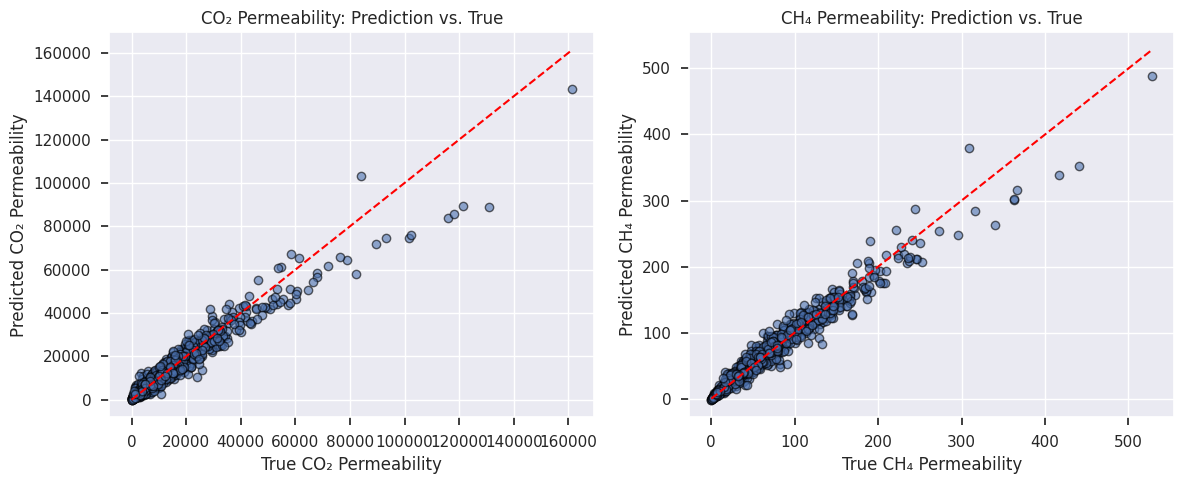

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(12,5))
axes[0].scatter(y_true_co2, y_pred_co2, alpha=0.6, edgecolor='k')
axes[0].plot([y_true_co2.min(), y_true_co2.max()], [y_true_co2.min(), y_true_co2.max()], 'r--')
axes[0].set_title('CO₂ Permeability: Prediction vs. True')
axes[0].set_xlabel('True CO₂ Permeability')
axes[0].set_ylabel('Predicted CO₂ Permeability')

axes[1].scatter(y_true_ch4, y_pred_ch4, alpha=0.6, edgecolor='k')
axes[1].plot([y_true_ch4.min(), y_true_ch4.max()], [y_true_ch4.min(), y_true_ch4.max()], 'r--')
axes[1].set_title('CH₄ Permeability: Prediction vs. True')
axes[1].set_xlabel('True CH₄ Permeability')
axes[1].set_ylabel('Predicted CH₄ Permeability')

plt.tight_layout()
plt.show()


/home/jovyan/.mlspace/envs/bolgov_simson_training/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/jovyan/.mlspace/envs/bolgov_simson_training/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


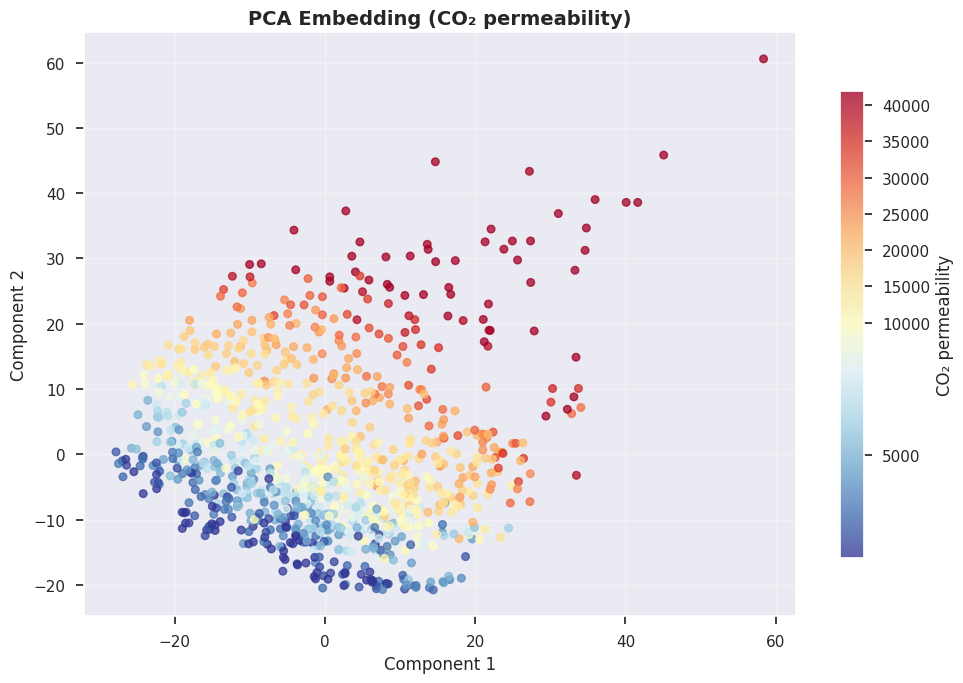

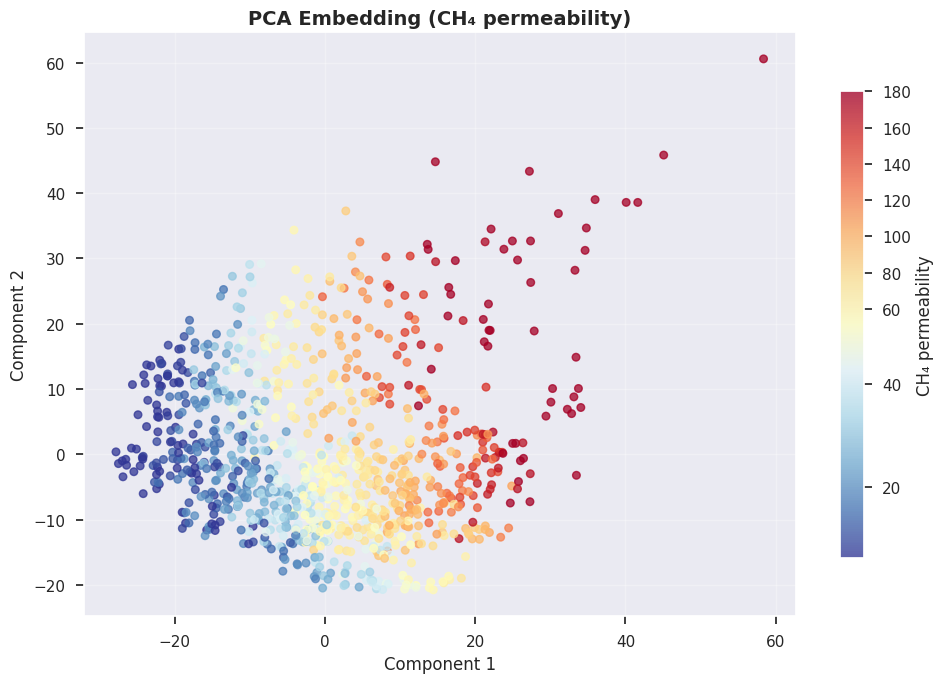

In [10]:
# Choose dimensionality reducer
import matplotlib.colors as mcolors
import numpy as np

pca = PCA(n_components=2)
embeddings_2d_pca = pca.fit_transform(embeddings)

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embeddings_2d_tsne = tsne.fit_transform(embeddings)

umap_reducer = umap.UMAP(n_components=2, random_state=42)
embeddings_2d_umap = umap_reducer.fit_transform(embeddings)

def plot_embedding_2d_log(emb_2d, vals, title, label):
    plt.figure(figsize=(10, 7))
    
    # Add small constant to avoid log(0) issues
    vals_positive = vals - vals.min() + 1e-10
    vals_log = np.log10(vals_positive)
    
    scatter = plt.scatter(emb_2d[:,0], emb_2d[:,1], 
                         c=vals_log, 
                         cmap='plasma', 
                         alpha=0.75, 
                         s=30)
    
    cbar = plt.colorbar(scatter, shrink=0.8)
    cbar.set_label(f'log₁₀({label})', fontsize=12)
    plt.title(f'{title} (Log Scale)', fontsize=14, fontweight='bold')
    plt.xlabel('Component 1', fontsize=12)
    plt.ylabel('Component 2', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_embedding_2d_improved(emb_2d, vals, title, label):
    plt.figure(figsize=(10, 7))
    
    # Use percentiles to handle outliers (clips top/bottom 5%)
    vmin = np.percentile(vals, 5)
    vmax = np.percentile(vals, 95)
    
    # Use a diverging colormap centered on median
    vcenter = np.median(vals)
    norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
    
    scatter = plt.scatter(emb_2d[:,0], emb_2d[:,1], 
                         c=vals, 
                         cmap='RdYlBu_r',  # Better for continuous data
                         alpha=0.75, 
                         s=30,  # Slightly larger points
                         norm=norm)
    
    cbar = plt.colorbar(scatter, shrink=0.8)
    cbar.set_label(label, fontsize=12)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel('Component 1', fontsize=12)
    plt.ylabel('Component 2', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_embedding_2d_quantile(emb_2d, vals, title, label, n_bins=10):
    plt.figure(figsize=(10, 7))
    
    # Create quantile-based bins
    quantiles = np.linspace(0, 100, n_bins + 1)
    bin_edges = np.percentile(vals, quantiles)
    vals_binned = np.digitize(vals, bin_edges) - 1
    
    scatter = plt.scatter(emb_2d[:,0], emb_2d[:,1], 
                         c=vals_binned, 
                         cmap='tab10' if n_bins <= 10 else 'viridis', 
                         alpha=0.75, 
                         s=30)
    
    cbar = plt.colorbar(scatter, shrink=0.8)
    cbar.set_label(f'{label} (Decile)', fontsize=12)
    cbar.set_ticks(range(n_bins))
    cbar.set_ticklabels([f'Q{i+1}' for i in range(n_bins)])
    
    plt.title(f'{title} (Quantile Binned)', fontsize=14, fontweight='bold')
    plt.xlabel('Component 1', fontsize=12)
    plt.ylabel('Component 2', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()



pca = PCA(n_components=2)
embeddings_2d_pca = pca.fit_transform(embeddings)

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embeddings_2d_tsne = tsne.fit_transform(embeddings)

umap_reducer = umap.UMAP(n_components=2, random_state=42)
embeddings_2d_umap = umap_reducer.fit_transform(embeddings)

# Method 1: Percentile-based scaling (recommended for most cases)
plot_embedding_2d_improved(embeddings_2d_pca, y_true_co2, 'PCA Embedding (CO₂ permeability)', 'CO₂ permeability')
#plot_embedding_2d_improved(embeddings_2d_tsne, y_true_co2, 't-SNE Embedding (CO₂ permeability)', 'CO₂ permeability')
#plot_embedding_2d_improved(embeddings_2d_umap, y_true_co2, 'UMAP Embedding (CO₂ permeability)', 'CO₂ permeability')

# Method 2: Log scale (if values span orders of magnitude)
plot_embedding_2d_improved(embeddings_2d_pca, y_true_ch4, 'PCA Embedding (CH₄ permeability)', 'CH₄ permeability')
#plot_embedding_2d_improved(embeddings_2d_tsne, y_true_ch4, 't-SNE Embedding (CH₄ permeability)', 'CH₄ permeability')
#plot_embedding_2d_improved(embeddings_2d_umap, y_true_ch4, 'UMAP Embedding (CH₄ permeability)', 'CH₄ permeability')

# Method 3: Quantile binning (for categorical-like visualization)
# plot_embedding_2d_quantile(embeddings_2d_umap, y_true_co2, 'PCA Embedding (CO₂ permeability)', 'CO₂ permeability', n_bins=8)


In [11]:
# Compute the first principal component of the embeddings
pc1 = pca.components_[0]
projected = embeddings @ pc1  # Project embeddings onto PC1

from scipy.stats import pearsonr
corr_co2 = pearsonr(projected, y_true_co2)[0]
corr_ch4 = pearsonr(projected, y_true_ch4)[0]
print(f'Correlation between PC1 and CO2 permeability: {corr_co2:.3f}')
print(f'Correlation between PC1 and CH4 permeability: {corr_ch4:.3f}')


Correlation between PC1 and CO2 permeability: 0.519
Correlation between PC1 and CH4 permeability: 0.853
